# Stochastic Optimization

## 3.3 NSGA-II

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

To explore NSGA-II, we'll use the [PyMOO](https://pymoo.org/algorithms/nsga2.html) library and a Multi-Objective Travelling Salesman Problem. For the different objectives, we'll construct random distance matrices, but we could imagine, for example, that one objective is travel time between two points and a second objective is travel cost. We want to minimize both objectives, choosing a route from the Pareto front of quick and low-cost travel.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

First, we define the Multi-Objective Travelling Salesman Problem using the `ElementwiseProblem` class from `pymoo`. We'll define it to take any number of cities and objectives, returning a fitness of the total distance from each objective for the given individual. We specify a constraint on the order to ensure we're visiting each city once, but we'll also define the same operators as in the GA notebook to make sure all individuals meet this constraint.

In [2]:
from pymoo.core.problem import ElementwiseProblem

class MOTSP(ElementwiseProblem):
    
    def __init__(self, n_cities, n_obj):
        # lower bound
        xl = np.zeros(n_cities)
        # upper bound
        xu = (n_cities-1) * np.ones(n_cities)
        
        self.n_cities = n_cities
        self.distances = []
        for i in range(n_obj):
            # random symmetric matrix
            d = np.random.rand(n_cities, n_cities)
            d = np.tril(d) + np.tril(d, -1).T
            d[np.diag_indices(n_cities)] = 0
            self.distances.append(d)
        
        super().__init__(n_var=n_cities, n_obj=n_obj, n_constr=1,
                        xl=xl, xu=xu)
        
    def total_distance(self, x, d):
        t = 0
        for i in range(1, len(x)):
            t += self.distances[d][x[i-1], x[i]]
        return t
    
    def _evaluate(self, x, out, *args, **kwargs):
        # fitness based on each distance matrix
        fits = np.zeros(len(self.distances))
        for i in range(len(self.distances)):
            fits[i] = self.total_distance(x, i)
        
        # constraints return negative if met
        c = -np.sum(np.arange(self.n_cities) != np.sort(x))
        
        # return by modifying out
        out["F"] = np.column_stack(fits)
        out["G"] = np.array([c])

Next, we define NSGA2, its hyperparameters and operators. We'll use the same operators as before. Note that `pymoo` allows for generating fewer offspring than the initial population size and that it can check for duplicates. We'll use this second feature.

In [3]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.erx import EdgeRecombinationCrossover
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.mutation.inversion import InversionMutation

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=PermutationRandomSampling(),
    crossover=EdgeRecombinationCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

To start, let's define a 50-city problem with 2 objectives. As mentioned, these could be total travel time and total travel cost. We want to minimize both objectives. Note the use of `seed=1` in the call to `minimize`: this optimization is deterministic (we can run it multiple times and get the same result).

In [4]:
problem = MOTSP(50, 2)

In [5]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               seed=1,
               save_history=True,
               verbose=False)

The `res` object returned from the search contains the results, including the final Pareto front.

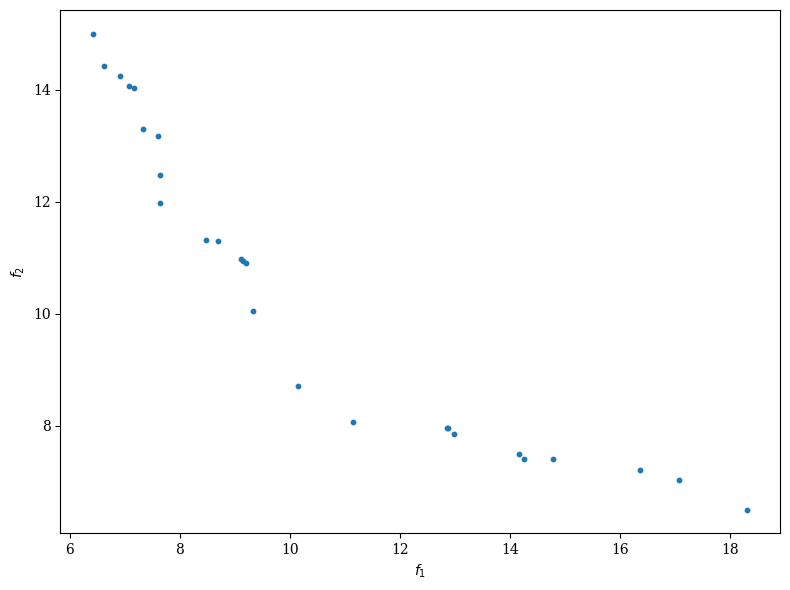

In [6]:
from pymoo.visualization.scatter import Scatter
plot = Scatter(tight_layout=True)
plot.add(res.F, s=10)
plot.show();

We can also visualize the convergence of each objective. We'll plot the fitness of the first individual in the Pareto front over evolution. Note that this isn't the best value for each objective independently, but rather the objective values of a single individual.

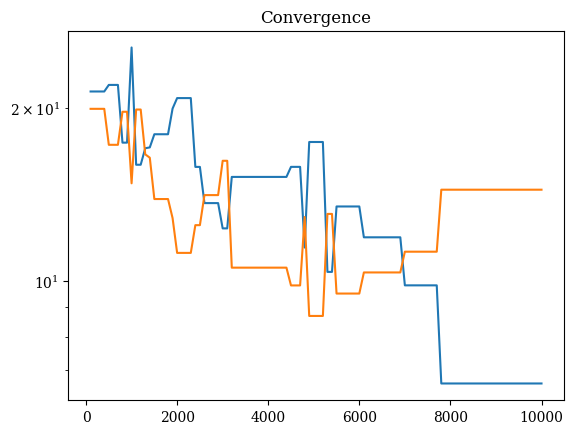

In [7]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, opt)
plt.yscale("log")
plt.show()

As the number of dimensions grows, visualizing the convergence across all objectives becomes difficult. One recently proposed metric known as the "running metric" evaluates non-dominated sets from each generation relative to previously recorded sets. This gives an idea of how much the Pareto front has moved in any generation. For visualizing this running metric, each ND set is normalized by the final ND set after a certain number of generations. The difference between intervals then gives an idea if the algorithm is converging.

![Running metric](imgs/running_metric.png)

Blank, Julian, and Kalyanmoy Deb. "A running performance metric and termination criterion for evaluating evolutionary multi-and many-objective optimization algorithms." Proc. IEEE World Congr. Comput. Intell.(WCCI). 2020.

https://www.egr.msu.edu/~kdeb/papers/c2020003.pdf

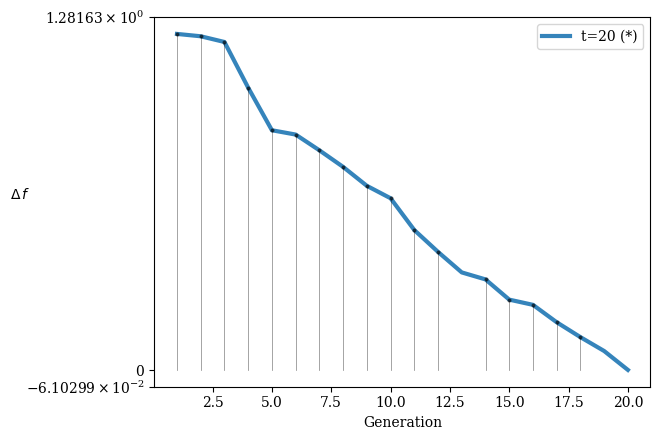

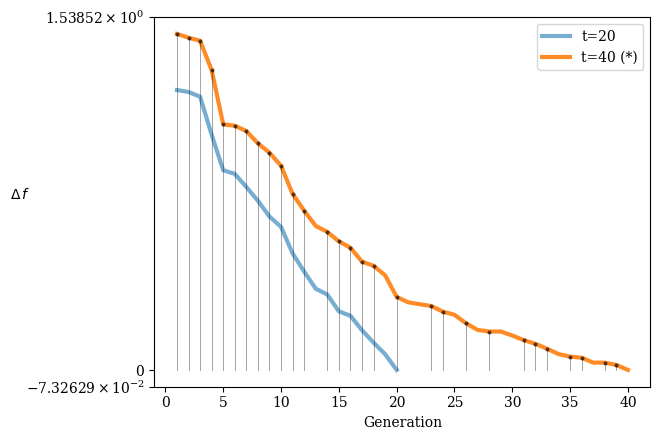

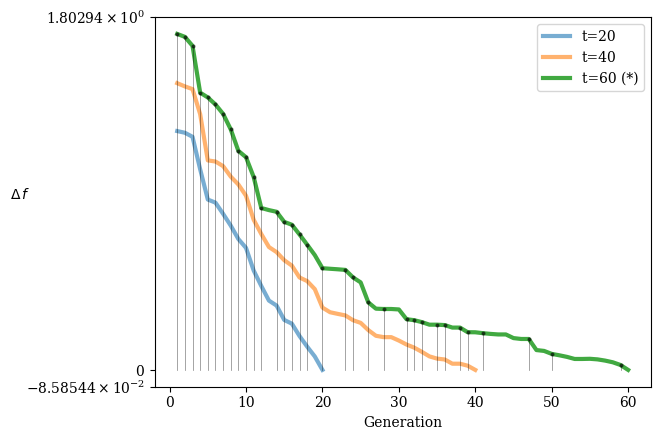

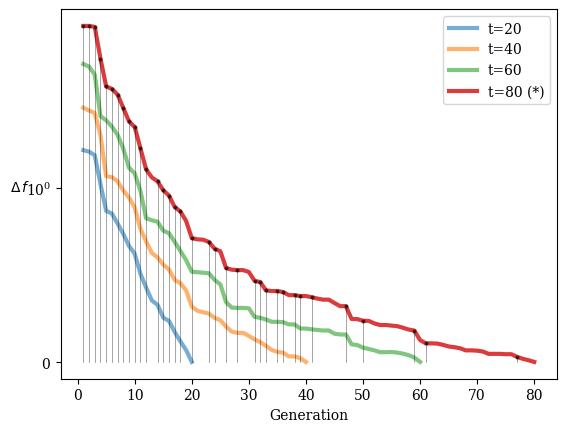

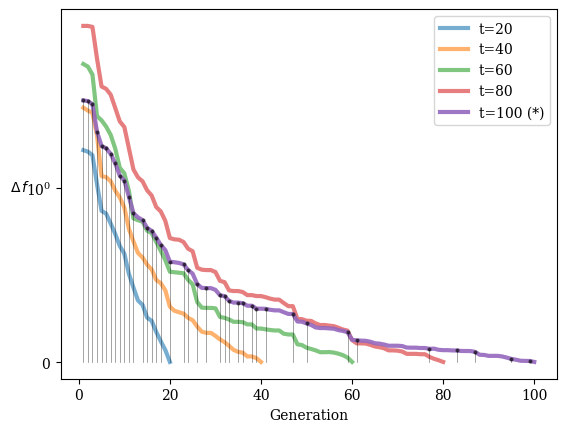

In [ ]:
from pymoo.util.running_metric import RunningMetricAnimation
running = RunningMetricAnimation(delta_gen=20,
                        n_plots=5,
                        key_press=False,
                        do_show=True)

for algorithm in res.history:
    running.update(algorithm)

<div class="alert alert-success">
    <h3>Exercise 1</h3>

Increase the number of objectives and observe the convergence of NSGA-II. Roughly, how much does each objective change convergence speed?
</div>

<div class="alert alert-success">
    <h3>Exercise 2</h3>

Visualizing populations in many-objective optimization is also difficult. Look at the [visualization](http://pymoo.org/visualization/index.html) options in pymoo and try to visualize populations with more than 5 objectives. What plot makes most sense to you?
</div>

# Manufacturing Process Parameter Optimization Using NSGA-II

After exploring the Multi-Objective Travelling Salesman Problem with NSGA-II, let's apply this algorithm to a practical engineering scenario: manufacturing process parameter optimization.

## Problem Description

In manufacturing processes, engineers often need to balance multiple competing objectives. We'll simulate a manufacturing process with three key parameters that need to be optimized:

1. **Temperature** (°C): Acceptable range 150-250°C
2. **Pressure** (MPa): Acceptable range 5-15 MPa
3. **Processing time** (min): Acceptable range 10-30 minutes

The goal is to optimize these parameters to achieve multiple objectives:
- **Maximize production rate** (units/hour)
- **Minimize defect rate** (%)
- **Minimize energy consumption** (kWh)

Let's start by importing the necessary libraries:

In [ ]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

## Defining the Manufacturing Problem

We'll now define our manufacturing process optimization problem using PyMOO's `ElementwiseProblem` class. This problem will have constraints to ensure our parameters stay within acceptable ranges.


In [ ]:
class ManufacturingProblem(ElementwiseProblem):
    
    def __init__(self):
        # Define variable bounds
        xl = np.array([150.0, 5.0, 10.0])  # Lower bounds: [temp, pressure, time]
        xu = np.array([250.0, 15.0, 30.0])  # Upper bounds: [temp, pressure, time]
        
        # Initialize the problem
        # 3 variables (temperature, pressure, processing time)
        # 3 objectives (production rate, defect rate, energy consumption)
        # 0 constraints (we'll handle bounds directly)
        super().__init__(n_var=3, n_obj=3, n_constr=0, xl=xl, xu=xu)
    
    def _evaluate(self, x, out, *args, **kwargs):
        temperature, pressure, process_time = x
        
        # Objective 1: Production Rate (to be maximized, so we negate)
        # Higher temperature and pressure increase production rate
        # Longer processing time decreases production rate
        production_rate = (
            20 + 0.1 * (temperature - 150) 
            + 2 * (pressure - 5) 
            - 0.8 * (process_time - 10)
        )
        
        # Add some non-linearity to production rate
        production_rate += 5 * np.sin(temperature/25) * np.cos(pressure**2/9)
        
        # Objective 2: Defect Rate (to be minimized)
        # Temperature and pressure have sweet spots
        # Longer processing time generally reduces defects
        defect_rate = 5.0
        defect_rate += 0.05 * (temperature - 200)**2 / 25
        defect_rate += 0.5 * (pressure - 10)**2
        defect_rate -= 0.1 * (process_time - 10)
        
        # Add some non-linearity to defect rate
        defect_rate += 2 * np.sin(temperature**3/(20**3)) * np.sin(pressure/2)
        
        # Bound defect rate
        defect_rate = np.clip(defect_rate, 0, 100)
        
        # Objective 3: Energy Consumption (to be minimized)
        # Higher temperatures, pressures, and longer times increase energy usage
        energy = 10.0
        energy += 0.2 * (temperature - 150)
        energy += 1.5 * (pressure - 5)
        energy += 0.5 * process_time
        
        # Return objectives (note: we negate production rate since NSGA-II minimizes by default)
        out["F"] = np.column_stack([
            -production_rate,  # Negate for maximization
            defect_rate,
            energy
        ])

## Configuring and Running NSGA-II

Next, we'll set up the NSGA-II algorithm with appropriate operators for our real-valued optimization problem:


In [ ]:
# Configure NSGA-II
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Create the problem instance
problem = ManufacturingProblem()

In [ ]:
# Run the optimization
res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               save_history=True,
               verbose=True)

## Visualizing the Results

Let's visualize the Pareto front obtained from our optimization:

In [ ]:
# Plot the Pareto front
scatter = Scatter(title="Manufacturing Process Optimization", 
                  labels=["Neg. Production Rate", "Defect Rate", "Energy Consumption"])
scatter.add(res.F, s=10)
scatter.show()

# Create a better visualization with axis labels indicating the actual objectives
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract Pareto front points
x = -res.F[:, 0]  # Convert back to positive production rate
y = res.F[:, 1]   # Defect rate
z = res.F[:, 2]   # Energy consumption

# Create 3D scatter plot
scatter = ax.scatter(x, y, z, c='blue', marker='o', alpha=0.6)

# Set labels and title
ax.set_xlabel('Production Rate (units/hour)')
ax.set_ylabel('Defect Rate (%)')
ax.set_zlabel('Energy Consumption (kWh)')
ax.set_title('Pareto Front for Manufacturing Process Optimization')

plt.tight_layout()
plt.show()

Let's extract and analyze some representative solutions from the Pareto front:

In [ ]:
# Select solutions focusing on each objective
production_focused_idx = np.argmin(res.F[:, 0])  # Best production (minimize negative)
defect_focused_idx = np.argmin(res.F[:, 1])      # Best defect rate
energy_focused_idx = np.argmin(res.F[:, 2])      # Best energy consumption

# Create a compromise solution (closest to ideal point)
ideal_point = np.min(res.F, axis=0)
nadir_point = np.max(res.F, axis=0)
normalized_F = (res.F - ideal_point) / (nadir_point - ideal_point)
distances = np.linalg.norm(normalized_F, axis=1)
compromise_idx = np.argmin(distances)

# Extract the parameter values for these solutions
solutions = {
    "Production Focused": {
        "Parameters": res.X[production_focused_idx],
        "Objectives": [-res.F[production_focused_idx, 0], res.F[production_focused_idx, 1], res.F[production_focused_idx, 2]]
    },
    "Defect Focused": {
        "Parameters": res.X[defect_focused_idx],
        "Objectives": [-res.F[defect_focused_idx, 0], res.F[defect_focused_idx, 1], res.F[defect_focused_idx, 2]]
    },
    "Energy Focused": {
        "Parameters": res.X[energy_focused_idx],
        "Objectives": [-res.F[energy_focused_idx, 0], res.F[energy_focused_idx, 1], res.F[energy_focused_idx, 2]]
    },
    "Compromise": {
        "Parameters": res.X[compromise_idx],
        "Objectives": [-res.F[compromise_idx, 0], res.F[compromise_idx, 1], res.F[compromise_idx, 2]]
    }
}

# Print the solutions
print("Representative Solutions from the Pareto Front:\n")
for name, solution in solutions.items():
    params = solution["Parameters"]
    obj = solution["Objectives"]
    print(f"{name} Solution:")
    print(f"  Temperature: {params[0]:.2f}°C")
    print(f"  Pressure: {params[1]:.2f} MPa")
    print(f"  Processing Time: {params[2]:.2f} min")
    print(f"  Production Rate: {obj[0]:.2f} units/hour")
    print(f"  Defect Rate: {obj[1]:.2f}%")
    print(f"  Energy Consumption: {obj[2]:.2f} kWh")
    print()

<div class="alert alert-success">
    <h3>Exercise 3</h3>

Using the [visualization](http://pymoo.org/visualization/index.html) method you used before, visualize the final results of the algorithm.
</div>

# Production Scheduling Optimization Using NSGA-II

Next, we'll explore how to use NSGA-II to optimize a production scheduling problem. This extends our exploration of multi-objective optimization algorithms to a practical industrial engineering challenge.


## Problem Description

We need to determine the optimal batch sizes and sequence for producing multiple products on a single machine. This involves balancing three key objectives:

1. **Total Production Cost**: Setup costs plus production costs
2. **Makespan**: The total time required to complete all production
3. **Tardiness**: Delays in meeting delivery due dates

These objectives often conflict with each other. For example, minimizing makespan might require smaller batches, which increases setup costs and affects total production cost.

Let's start by importing the required libraries and setting up our problem parameters.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Import PyMOO libraries
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.visualization.pcp import PCP

## Problem Setup

We'll define the parameters of our scheduling problem, including:

- Number of products
- Setup times between different products
- Processing times for each product
- Production costs
- Due dates

These parameters represent a realistic production environment where changeovers between different products take time and cost money, and products have different processing requirements.


In [ ]:
# Number of products
N_PRODUCTS = 4

# Setup times between products (minutes)
SETUP_TIMES = np.array([
    [0, 30, 45, 60],   # From product 1 to products 1,2,3,4
    [30, 0, 40, 50],   # From product 2 to products 1,2,3,4
    [45, 40, 0, 35],   # From product 3 to products 1,2,3,4
    [60, 50, 35, 0]    # From product 4 to products 1,2,3,4
])

# Processing time per unit (minutes)
PROCESSING_TIMES = np.array([5, 7, 6, 8])

# Setup cost per minute
SETUP_COST_RATE = 2.0  # $2 per minute

# Production cost per unit
PRODUCTION_COSTS = np.array([10, 15, 12, 18])

# Holding cost per unit per day
HOLDING_COSTS = np.array([0.5, 0.8, 0.6, 1.0])

# Demand for each product
DEMAND = np.array([100, 80, 120, 60])

# Due dates for each product (in days from start)
DUE_DATES = np.array([5, 3, 7, 4])

# Working hours per day
HOURS_PER_DAY = 8

## Solution Representation and Decoding

In this multi-objective optimization problem using NSGA-II, we need a clear way to represent the solution. Our decision variables will be:

1. The batch size for each product
2. The sequence in which to produce the products

Here's how we'll decode this representation:


In [ ]:
def decode_solution(x):
    """
    Decode the solution vector to batch sizes and sequence.
    
    x is structured as:
    [batch_1, batch_2, ..., batch_N, seq_1, seq_2, ..., seq_N]
    
    where batch_i is the batch size for product i
    and seq_i is a value used to determine the sequence
    """
    n = N_PRODUCTS
    
    # Extract batch sizes and sequence values
    batch_sizes = np.round(np.clip(x[:n], 0, DEMAND)).astype(int)
    sequence_values = x[n:2*n]
    
    # Determine sequence by sorting the sequence values
    sequence = np.argsort(sequence_values)
    
    return batch_sizes, sequence

## Defining the Multi-Objective Problem

Now we'll define our production scheduling problem as a multi-objective optimization problem using PyMOO's `ElementwiseProblem` class. This problem will have three objectives:


In [ ]:
class ProductionSchedulingProblem(ElementwiseProblem):
    
    def __init__(self):
        # Define decision variable bounds
        # First N variables are batch sizes (0 to DEMAND)
        # Next N variables are sequence values (no specific bounds)
        xl = np.zeros(2 * N_PRODUCTS)
        xu = np.ones(2 * N_PRODUCTS)
        xu[:N_PRODUCTS] = DEMAND  # Upper bound for batch sizes
        xu[N_PRODUCTS:] = 100     # Arbitrary upper bound for sequence values
        
        # Initialize the problem with 3 objectives
        super().__init__(n_var=2*N_PRODUCTS,    # Number of decision variables
                         n_obj=3,                # Number of objectives
                         n_constr=0,             # Number of constraints
                         xl=xl, xu=xu)           # Bounds on decision variables
    
    def _evaluate(self, x, out, *args, **kwargs):
        """
        Evaluate the objectives for a given solution x.
        """
        # Decode the solution
        batch_sizes, sequence = decode_solution(x)
        
        # Calculate objective 1: Total Production Cost
        cost = self._calculate_production_cost(batch_sizes, sequence)
        
        # Calculate objective 2: Makespan
        span = self._calculate_makespan(batch_sizes, sequence)
        
        # Calculate objective 3: Tardiness
        tardy = self._calculate_tardiness(batch_sizes, sequence)
        
        # Set the objective values (all to be minimized)
        out["F"] = np.array([cost, span, tardy])
    
    def _calculate_production_cost(self, batch_sizes, sequence):
        """
        Calculate the total production cost including setup costs and production costs.
        """
        # Initialize cost
        total_cost = 0
        
        # Add setup costs
        current_product = None
        for product_idx in sequence:
            # Skip products with zero batch size
            if batch_sizes[product_idx] == 0:
                continue
                
            if current_product is not None:
                # Add setup cost
                setup_time = SETUP_TIMES[current_product, product_idx]
                setup_cost = setup_time * SETUP_COST_RATE
                total_cost += setup_cost
                
            current_product = product_idx
            
            # Add production cost
            production_cost = batch_sizes[product_idx] * PRODUCTION_COSTS[product_idx]
            total_cost += production_cost
        
        # Penalize if all batch sizes are zero (invalid solution)
        if np.sum(batch_sizes) == 0:
            return 1000000
        
        # Penalize if not producing enough of any product
        for i in range(N_PRODUCTS):
            if batch_sizes[i] < DEMAND[i]:
                shortage = DEMAND[i] - batch_sizes[i]
                total_cost += shortage * PRODUCTION_COSTS[i] * 3  # High penalty for shortage
        
        return total_cost
    
    def _calculate_makespan(self, batch_sizes, sequence):
        """
        Calculate the makespan (total production time) in minutes.
        """
        # Initialize time
        total_time = 0
        
        # Add setup and processing times
        current_product = None
        for product_idx in sequence:
            # Skip products with zero batch size
            if batch_sizes[product_idx] == 0:
                continue
                
            if current_product is not None:
                # Add setup time
                total_time += SETUP_TIMES[current_product, product_idx]
                
            current_product = product_idx
            
            # Add processing time
            total_time += batch_sizes[product_idx] * PROCESSING_TIMES[product_idx]
        
        # Penalize if all batch sizes are zero (invalid solution)
        if np.sum(batch_sizes) == 0:
            return 100000
        
        return total_time
    
    def _calculate_tardiness(self, batch_sizes, sequence):
        """
        Calculate the total tardiness (sum of delays past due dates) in days.
        """
        # Convert minutes to days
        minutes_per_day = HOURS_PER_DAY * 60
        
        # Calculate completion time for each product
        current_time = 0
        current_product = None
        completion_times = np.zeros(N_PRODUCTS)
        
        for product_idx in sequence:
            # Skip products with zero batch size
            if batch_sizes[product_idx] == 0:
                continue
                
            if current_product is not None:
                # Add setup time
                current_time += SETUP_TIMES[current_product, product_idx]
                
            current_product = product_idx
            
            # Add processing time
            current_time += batch_sizes[product_idx] * PROCESSING_TIMES[product_idx]
            
            # Record completion time
            completion_times[product_idx] = current_time / minutes_per_day
        
        # Calculate tardiness (max of 0 and completion time - due date)
        tardiness_values = np.maximum(0, completion_times - DUE_DATES)
        
        # Additional penalty for not producing enough
        for i in range(N_PRODUCTS):
            if batch_sizes[i] < DEMAND[i]:
                tardiness_values[i] += 10  # Big penalty for not meeting demand
        
        return np.sum(tardiness_values)

## Configuring NSGA-II and Running the Optimization

Now we'll set up the NSGA-II algorithm with appropriate parameters and run the optimization:


In [ ]:
# Create the problem instance
problem = ProductionSchedulingProblem()

# Configure NSGA-II algorithm
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

In [ ]:
# Run the optimization
res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=True)

# Print optimization results
print(f"Number of non-dominated solutions: {len(res.F)}")


## Analyzing the Pareto Front

After running NSGA-II, we'll have a set of non-dominated solutions forming the Pareto front. Let's analyze and visualize these results:


In [ ]:
# Create a parallel coordinate plot to visualize the trade-offs
pcp = PCP(title="",
         labels=["Production Cost ($)", "Makespan (min)", "Tardiness (days)"])
pcp.add(res.F)
pcp.show();

In [ ]:
# Find solutions that minimize each objective
min_cost_idx = np.argmin(res.F[:, 0])
min_makespan_idx = np.argmin(res.F[:, 1])
min_tardiness_idx = np.argmin(res.F[:, 2])

# Find a compromise solution (use normalized Euclidean distance from ideal point)
ideal_point = np.min(res.F, axis=0)
nadir_point = np.max(res.F, axis=0)
normalized_F = (res.F - ideal_point) / (nadir_point - ideal_point)
distances = np.linalg.norm(normalized_F, axis=1)
compromise_idx = np.argmin(distances)

# Extract the solution details
solutions = [
    ("Cost-focused", res.X[min_cost_idx]),
    ("Makespan-focused", res.X[min_makespan_idx]),
    ("Tardiness-focused", res.X[min_tardiness_idx]),
    ("Compromise", res.X[compromise_idx])
]

# Analyze and display each solution
print("\nRepresentative Solutions from the Pareto Front:\n")
print("Solution Type | Production Cost | Makespan (days) | Tardiness (days) | Batch Sizes | Sequence")
print("-" * 110)

for name, x in solutions:
    batch_sizes, sequence = decode_solution(x)
    cost = problem._calculate_production_cost(batch_sizes, sequence)
    span = problem._calculate_makespan(batch_sizes, sequence)
    tardy = problem._calculate_tardiness(batch_sizes, sequence)
    
    makespan_days = span / (HOURS_PER_DAY * 60)
    
    batch_str = ", ".join([f"P{i+1}:{batch_sizes[i]}" for i in range(N_PRODUCTS)])
    seq_str = " → ".join([f"P{i+1}" for i in sequence if batch_sizes[i] > 0])
    
    print(f"{name:15} | ${cost:14.2f} | {makespan_days:14.2f} | {tardy:16.2f} | {batch_str:21} | {seq_str}")
    